## Cloudless Mosaic

This tutorial constructs a *cloudless mosaic* (also known as a composite) from a time series of satellite images. We'll see the following:

* Find a time series of images at a particular point on Earth
* Stack those images together into a single array
* Compute the cloudless mosaic by taking a median
* Visualize the results

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques used here apply equally well to other remote-sensing datasets.

In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import rioxarray
import stackstac
import pystac_client
import planetary_computer

import pyproj
from shapely.ops import transform
from shapely.geometry import Polygon

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

### Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [2]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.b1d686d7c09b4a6ea43a87bf0d172241/status


### Discover data

In this example, we define our area of interest as a GeoJSON object. It's near Redmond, Washington.

In [3]:
coords =[[175.9540924324072,-39.79467075565404],
        [175.945114873355,-39.5925815994339],
        [175.7466289836702,-39.59528350422168],
        [175.7518945072953,-39.79792833072585],
        [175.9540924324072,-39.79467075565404]]

# bbox = rasterio.features.bounds(area_of_interest)
pol = Polygon(coords)

# (minx, miny, maxx, maxy)
bbox = pol.bounds

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2016-01-01/2022-01-01",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 50}},
)

items = list(search.get_items())
print(len(items))

601


So 138 items match our search requirements, over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [5]:
%%time
signed_items = []
for item in items:
    item.clear_links()
    signed_items.append(planetary_computer.sign(item).to_dict())

CPU times: user 697 ms, sys: 2.65 ms, total: 700 ms
Wall time: 1.38 s


In [6]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B08"],
        chunksize=4096,
        resolution=10,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
)

# Get bounding box in projection of data
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS(data.crs), always_xy=True).transform
pol_utm = transform(project, pol)
minx, miny, maxx, maxy = pol_utm.bounds

# Subset data
data = data.sel(x=slice(minx, maxx), y=slice(maxy,miny), band='B08')
data

<xarray.DataArray 'stackstac-c8fafbd49bc31b05bc7483cc16d2cde2' (time: 601, y: 2300, x: 1807)>
dask.array<getitem, shape=(601, 2300, 1807), dtype=float64, chunksize=(1, 2300, 1807), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2016-01-10...
    id                                       (time) <U54 'S2A_MSIL2A_20160110...
    band                                     <U3 'B08'
  * x                                        (x) float64 3.924e+05 ... 4.104e+05
  * y                                        (y) float64 5.617e+06 ... 5.594e+06
    proj:epsg                                int64 32760
    ...                                       ...
    proj:shape                               object {10980}
    gsd                                      int64 10
    common_name                              <U3 'nir'
    center_wavelength                        float64 0.842
    full_width_half_max                      float64 0.145
    epsg                                     int64 32760
Attributes:
    spec:        RasterSpec(epsg=32760, bounds=(300000, 5490220, 509760, 5700...
    crs:         epsg:32760
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 5700040.00|\n| 0.0...
    resolution:  10

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [7]:
# data = data.persist()

## Grouped Yearly

In [9]:
grouped = data.groupby("time.year").median()

In [46]:
grouped = grouped.rename('NIR')
grouped = grouped.rio.write_crs(pyproj.CRS(data.crs).to_string())

Let's convert each of those arrays to a true-color image and plot the results as a grid.

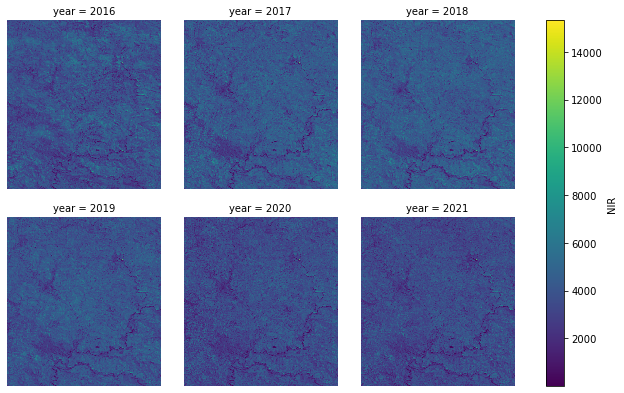

In [47]:
import matplotlib.pyplot as plt

g = grouped.plot.imshow(x="x", y="y", col="year", col_wrap=3)
for ax in g.axes.flat:
    ax.set_axis_off()

In [48]:
for y in grouped.year.to_numpy():
    grouped.sel(year=y).rio.to_raster(f's2_l2_{y}0601.tif')

## Grouped Yearly and Seasonally

In [8]:
import pandas as pd
year_season_idx = pd.MultiIndex.from_arrays([data['time.year'].to_numpy(), data['time.season'].to_numpy()])
data.coords['year_season'] = ('time', year_season_idx)

In [9]:
grouped = data.groupby('year_season').median()

In [10]:
grouped = grouped.rename('NIR')
grouped = grouped.rio.write_crs(pyproj.CRS(data.crs).to_string())

Let's convert each of those arrays to a true-color image and plot the results as a grid.

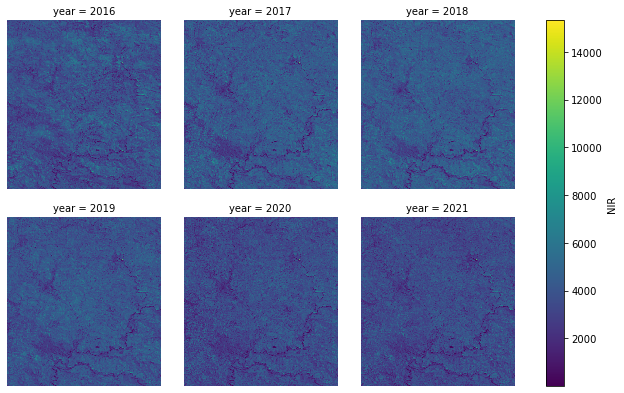

In [47]:
import matplotlib.pyplot as plt

g = grouped.plot.imshow(x='x', y='y', col='year_season', col_wrap=3)
for ax in g.axes.flat:
    ax.set_axis_off()

In [16]:
season_mid = {'DJF':'01','MAM':'04','JJA':'07','SON':'10'}

for i in grouped.year_season.to_numpy():
    y,s = i
    m = season_mid[s]
    out_name = f's2_l2_{y}{m}01.tif'
    grouped.sel(year_season=i).rio.to_raster(out_name)
    print(out_name)

s2_l2_20160101.tif
s2_l2_20160401.tif
s2_l2_20160701.tif
s2_l2_20161001.tif
s2_l2_20170101.tif
s2_l2_20170401.tif
s2_l2_20170701.tif
s2_l2_20171001.tif
s2_l2_20180101.tif
s2_l2_20180401.tif
s2_l2_20180701.tif
s2_l2_20181001.tif
s2_l2_20190101.tif
s2_l2_20190401.tif
s2_l2_20190701.tif
s2_l2_20191001.tif
s2_l2_20200101.tif
s2_l2_20200401.tif
s2_l2_20200701.tif
s2_l2_20201001.tif
s2_l2_20210101.tif
s2_l2_20210401.tif
s2_l2_20210701.tif
s2_l2_20211001.tif


### Learn more

To learn more about using the the Planetary Computer's STAC API, see [Reading data from the STAC API](../quickstarts/reading-stac.ipynb). To learn more about Dask, see [Scaling with Dask](../quickstarts/scale-with-dask.ipynb).